## Seizure Detection Challenge (2025) 


In [8]:
#Imports
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sweetviz
from sklearn.model_selection import train_test_split
import epilepsy2bids
import mne
import joblib
import imblearn

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 



### Exploratory Data Analysis

In [2]:
#BIDS_Siena Sub 00 ses-01 run 00
sub00ses01run00 = r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf"
sub00ses01run00 = mne.io.read_raw_edf(sub00ses01run00, preload=True)
print(sub00ses01run00.info)

Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 671999  =      0.000 ...  2624.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1-Avg, F3-Avg, C3-Avg, P3-Avg, O1-Avg, F7-Avg, T3-Avg, T5-Avg, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 1.6 Hz
 lowpass: 30.0 Hz
 meas_date: 2016-01-01 19:39:33 UTC
 nchan: 19
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


In [3]:
#View Channel Names
print(sub00ses01run00.ch_names)

['Fp1-Avg', 'F3-Avg', 'C3-Avg', 'P3-Avg', 'O1-Avg', 'F7-Avg', 'T3-Avg', 'T5-Avg', 'Fz-Avg', 'Cz-Avg', 'Pz-Avg', 'Fp2-Avg', 'F4-Avg', 'C4-Avg', 'P4-Avg', 'O2-Avg', 'F8-Avg', 'T4-Avg', 'T6-Avg']


Using matplotlib as 2D backend.


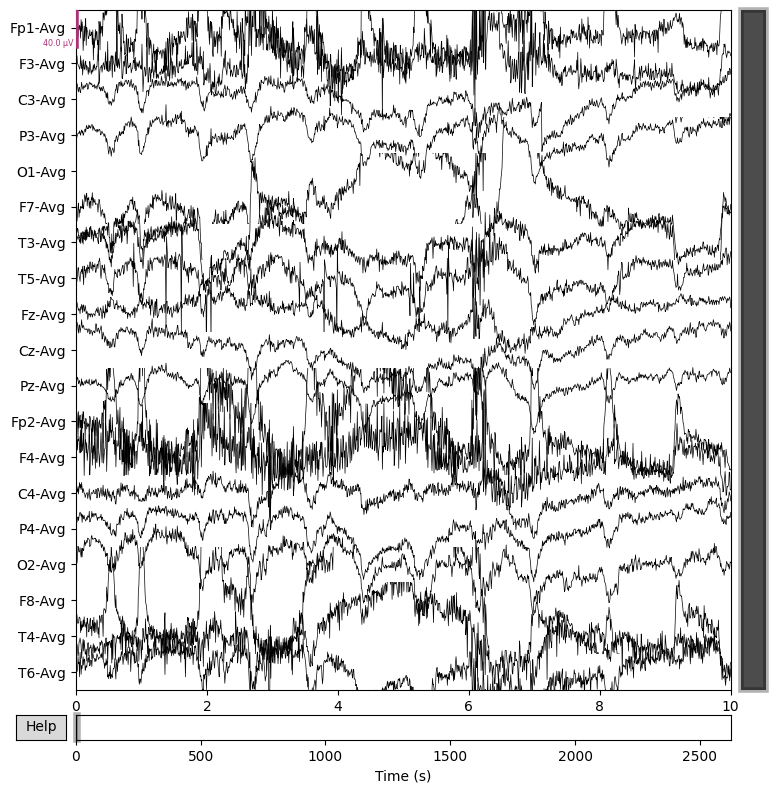

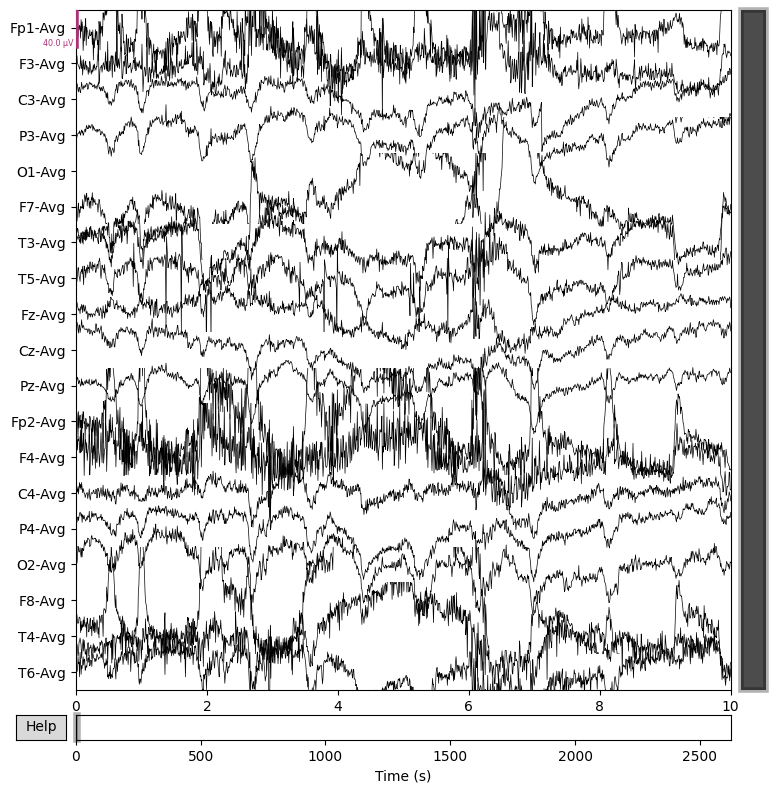

In [4]:
sub00ses01run00.plot(duration=10, n_channels=19)

In [5]:
# Extract EEG data as a NumPy array
eeg_data = sub00ses01run00.get_data()
channel_names = sub00ses01run00.ch_names

# Compute basic statistics
eeg_stats = pd.DataFrame({
    "Channel": channel_names,
    "Mean": np.mean(eeg_data, axis=1),
    "Std Dev": np.std(eeg_data, axis=1),
    "Min": np.min(eeg_data, axis=1),
    "Max": np.max(eeg_data, axis=1)
})

# Display the computed statistics
print(eeg_stats)


    Channel          Mean   Std Dev       Min       Max
0   Fp1-Avg -4.934503e-07  0.000049 -0.000430  0.001162
1    F3-Avg  1.461965e-08  0.000020 -0.000239  0.000494
2    C3-Avg -2.182140e-06  0.000016 -0.000343  0.000216
3    P3-Avg -1.308922e-06  0.000026 -0.000308  0.000950
4    O1-Avg -1.614275e-06  0.000095 -0.001081  0.002979
5    F7-Avg  1.795892e-06  0.000035 -0.000349  0.000406
6    T3-Avg -4.000901e-07  0.000022 -0.000466  0.000198
7    T5-Avg  3.125583e-06  0.000018 -0.000402  0.000203
8    Fz-Avg  4.814427e-07  0.000019 -0.000217  0.000315
9    Cz-Avg -4.819394e-06  0.000041 -0.000250  0.001165
10   Pz-Avg -1.682614e-06  0.000036 -0.000280  0.001136
11  Fp2-Avg  2.336533e-06  0.000055 -0.000461  0.001377
12   F4-Avg -4.353400e-07  0.000021 -0.000211  0.000637
13   C4-Avg -2.405176e-06  0.000017 -0.000202  0.000224
14   P4-Avg  9.287732e-07  0.000017 -0.000206  0.000174
15   O2-Avg  6.411352e-07  0.000026 -0.000304  0.000235
16   F8-Avg  2.965402e-06  0.000044 -0.000449  0

Computes the mean, standard deviation, min and max values for each EEG channel.

Helps in detecting anomalies, identifying bad channels and understanding the data distribution.

In [16]:
#Loading Seizure Annotations
sub00ses01run00_annotations = r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_events.tsv"
sub00ses01run00_annotations = pd.read_csv(sub00ses01run00_annotations, sep='\t')
print(sub00ses01run00_annotations.head())

    onset  duration  eventType  confidence channels             dateTime  \
0  1143.0      70.0  sz_foc_ia         NaN    T4,T6  2016-01-01 19:39:33   

   recordingDuration  
0             2625.0  


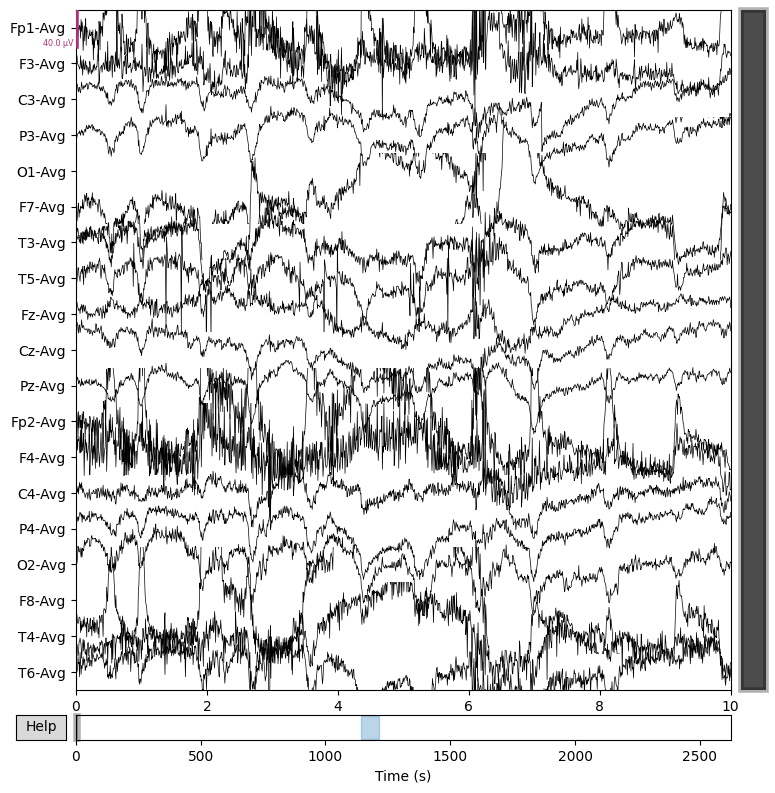

    onset  duration  eventType  confidence channels             dateTime  \
0  1143.0      70.0  sz_foc_ia         NaN    T4,T6  2016-01-01 19:39:33   

   recordingDuration  
0             2625.0  


In [22]:
# Create MNE Annotations object
mne_annotations = mne.Annotations(
    onset=sub00ses01run00_annotations["onset"].values,
    duration=sub00ses01run00_annotations["duration"].values,
    description=sub00ses01run00_annotations["eventType"].values
)

# Set annotations to the raw EEG object
sub00ses01run00.set_annotations(mne_annotations)

# Plot EEG data with annotations
sub00ses01run00.plot()

# Print first few rows of the annotations DataFrame
print(sub00ses01run00_annotations.head())

Electrode Labels on the left
    - These are the the EEG channel names corresponding to the standard 10-20 system electrode placements
EEG Signal Traces
    -Each Channel shows its recorded electrical activity over time in microvolts (µV). These signals represent the brain activity, and you may observe rhythmic patterns, spikes, or artifacts.
Time Axis (x-axis)

Highlighted Blue
    -Added Annotation (probably start and duration of seizure event)

### Example Usage of epilepsy2bids
The primary function of ep2bid is to convert EEG dataset to BIDS by calling convert() on a given dataset.

In [6]:
from epilepsy2bids.bids.chbmit.convert2bids import convert

#convert(root: Path, outDir: Path)